In [1]:
import math
from collections import defaultdict
from typing import List
from random import choices

class NGramLM:
    def __init__(self, n: int):
        self.n = n
        self.ngram_counts = defaultdict(int)
        self.context_counts = defaultdict(int)
        self.vocab = set()
        self.total_ngrams = 0

    def update(self, sentence: str):
        tokens = ["<s>"] * (self.n - 1) + sentence.strip().split() + ["</s>"]
        self.vocab.update(tokens)
        for i in range(len(tokens) - self.n + 1):
            ngram = tuple(tokens[i:i + self.n])
            context = tuple(tokens[i:i + self.n - 1])
            self.ngram_counts[ngram] += 1
            self.context_counts[context] += 1
            self.total_ngrams += 1

    def prob(self, ngram: tuple, smoothing: str = "none") -> float:
        context = ngram[:-1]
        vocab_size = len(self.vocab)
        count_ngram = self.ngram_counts[ngram]
        count_context = self.context_counts[context]

        if smoothing == "laplace":
            return (count_ngram + 1) / (count_context + vocab_size)
        elif smoothing == "none":
            if count_context == 0:
                return 1 / vocab_size
            return count_ngram / count_context
        else:
            raise ValueError(f"Unsupported smoothing method: {smoothing}")

    def generate(self, max_tokens=20, smoothing: str = "none") -> str:
        context = ["<s>"] * (self.n - 1)
        result = []
        for _ in range(max_tokens):
            candidates = [ng for ng in self.ngram_counts if ng[:-1] == tuple(context)]
            if not candidates:
                break
            probs = [self.prob(ng, smoothing=smoothing) for ng in candidates]
            next_token = choices([ng[-1] for ng in candidates], weights=probs)[0]
            if next_token == "</s>":
                break
            result.append(next_token)
            context = (context + [next_token])[1:]
        return " ".join(result)

    def perplexity(self, sentence: str, smoothing: str = "none") -> float:
        tokens = ["<s>"] * (self.n - 1) + sentence.strip().split() + ["</s>"]
        log_prob = 0.0
        for i in range(len(tokens) - self.n + 1):
            ngram = tuple(tokens[i:i + self.n])
            prob = self.prob(ngram, smoothing=smoothing)
            log_prob += math.log(prob if prob > 0 else 1e-10)
        return math.exp(-log_prob / (len(tokens) - self.n + 1))

    def loss(self, sentence: str, smoothing: str = "none") -> float:
        # Simple negative log-likelihood loss
        tokens = ["<s>"] * (self.n - 1) + sentence.strip().split() + ["</s>"]
        nll = 0.0
        for i in range(len(tokens) - self.n + 1):
            ngram = tuple(tokens[i:i + self.n])
            prob = self.prob(ngram, smoothing=smoothing)
            nll -= math.log(prob if prob > 0 else 1e-10)
        return nll

def create_ngramlm(n: int, file_paths: List[str]) -> NGramLM:
    model = NGramLM(n)
    for path in file_paths:
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                model.update(line.strip())
    return model

def predict_next_word(model: NGramLM, starter: str, smoothing: str = "none"):
    context = starter.strip().split()
    if len(context) < model.n - 1:
        context = ["<s>"] * (model.n - 1 - len(context)) + context
    else:
        context = context[-(model.n - 1):]

    candidates = []
    for ngram in model.ngram_counts:
        if ngram[:-1] == tuple(context):
            candidates.append((ngram[-1], model.prob(ngram, smoothing=smoothing)))

    if not candidates:
        return "No prediction available (context not seen in training)."

    candidates.sort(key=lambda x: x[1], reverse=True)
    best_word, best_prob = candidates[0]
    return f"Next likely word: '{best_word}' (p = {best_prob:.4f})"

# === Example usage ===
file_list = [
    "alice_wonderland.txt", "life_mississippi.txt", "sherlock_holmes.txt", "dracula.txt", "good_and_evil.txt",
    "edgar_poe.txt", "wit_and_humor.txt", "moby_dick.txt", "shakespeare.txt", "grimms.txt"
]

unigram = create_ngramlm(1, file_list)
bigram = create_ngramlm(2, file_list)
trigram = create_ngramlm(3, file_list)

starter = "I am"
print("Starter:", starter)
print("Unigram prediction:", predict_next_word(unigram, starter))
print("Bigram prediction:", predict_next_word(bigram, starter))
print("Trigram prediction:", predict_next_word(trigram, starter))

for model, name in [(unigram, "Unigram"), (bigram, "Bigram"), (trigram, "Trigram")]:
    print(f"\n{name} Model Generated Sentence:")
    print(model.generate(smoothing="laplace"))

    test_sentence = "this is a test sentence"
    print(f"{name} Model Perplexity for '{test_sentence}':")
    print(model.perplexity(test_sentence, smoothing="laplace"))

    print(f"{name} Model Loss for '{test_sentence}':")
    print(model.loss(test_sentence, smoothing="laplace"))


Starter: I am
Unigram prediction: No prediction available (context not seen in training).
Bigram prediction: Next likely word: 'not' (p = 0.0716)
Trigram prediction: Next likely word: 'not' (p = 0.0771)

Unigram Model Generated Sentence:
let LADY
Unigram Model Perplexity for 'this is a test sentence':
666.2231674011149
Unigram Model Loss for 'this is a test sentence':
39.009748203596466

Bigram Model Generated Sentence:
He suddenly upon him, lad, and quinces in which exhausted and odd,” said she. ‘But, grandmother, what end? And knit
Bigram Model Perplexity for 'this is a test sentence':
5141.135170894673
Bigram Model Loss for 'this is a test sentence':
51.27017510660383

Trigram Model Generated Sentence:

Trigram Model Perplexity for 'this is a test sentence':
26355.826705183666
Trigram Model Loss for 'this is a test sentence':
61.07666794113547



📄 alice_wonderland.txt
- Total sentences: 2803
- Total tokens: 29564
- Unique tokens: 5972


/tmp/ipython-input-4-1711993056.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="magma")



📄 life_mississippi.txt
- Total sentences: 12841
- Total tokens: 147531
- Unique tokens: 24158


/tmp/ipython-input-4-1711993056.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="magma")



📄 sherlock_holmes.txt
- Total sentences: 9621
- Total tokens: 107553
- Unique tokens: 15183


/tmp/ipython-input-4-1711993056.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="magma")



📄 dracula.txt
- Total sentences: 13373
- Total tokens: 164351
- Unique tokens: 18985


/tmp/ipython-input-4-1711993056.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="magma")



📄 good_and_evil.txt
- Total sentences: 6006
- Total tokens: 65730
- Unique tokens: 14565


/tmp/ipython-input-4-1711993056.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="magma")



📄 edgar_poe.txt
- Total sentences: 9514
- Total tokens: 98100
- Unique tokens: 18445


/tmp/ipython-input-4-1711993056.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="magma")



📄 wit_and_humor.txt
- Total sentences: 6570
- Total tokens: 58181
- Unique tokens: 15788


/tmp/ipython-input-4-1711993056.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="magma")



📄 moby_dick.txt
- Total sentences: 19222
- Total tokens: 215838
- Unique tokens: 33565


/tmp/ipython-input-4-1711993056.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="magma")



📄 shakespeare.txt
- Total sentences: 153926
- Total tokens: 966501
- Unique tokens: 71596


/tmp/ipython-input-4-1711993056.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="magma")



📄 grimms.txt
- Total sentences: 8301
- Total tokens: 104151
- Unique tokens: 10917


/tmp/ipython-input-4-1711993056.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="magma")



📄 ALL_COMBINED
- Total sentences: 242177
- Total tokens: 1957500
- Unique tokens: 135795


/tmp/ipython-input-4-1711993056.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="magma")


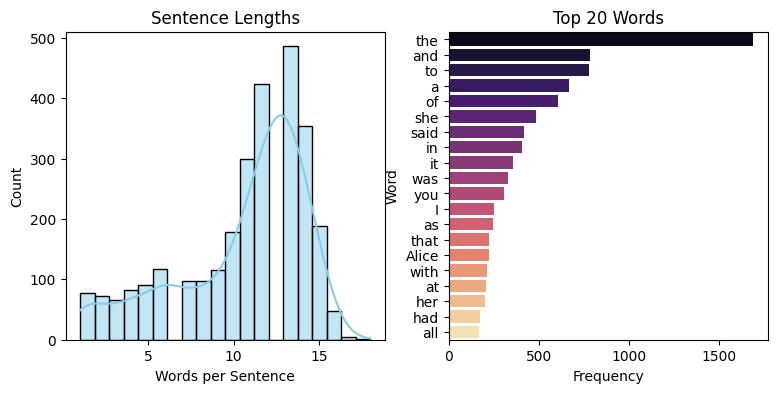

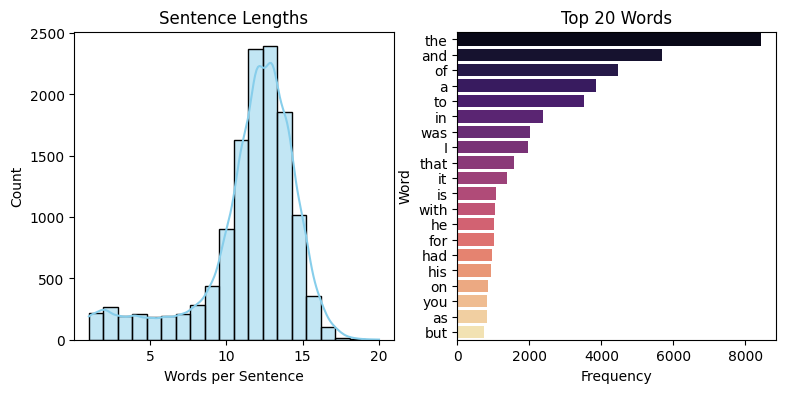

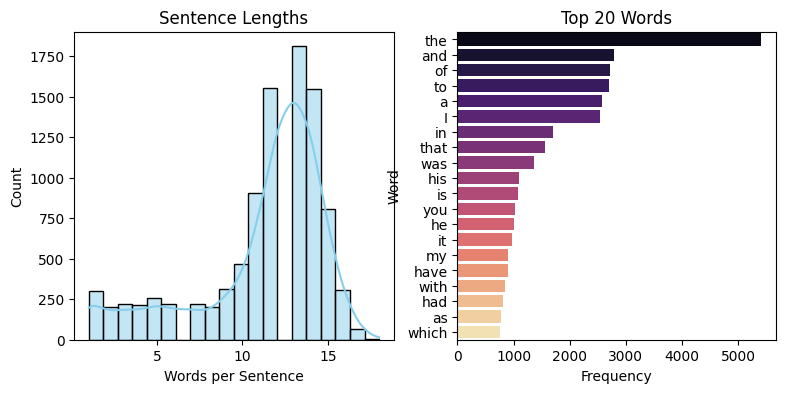

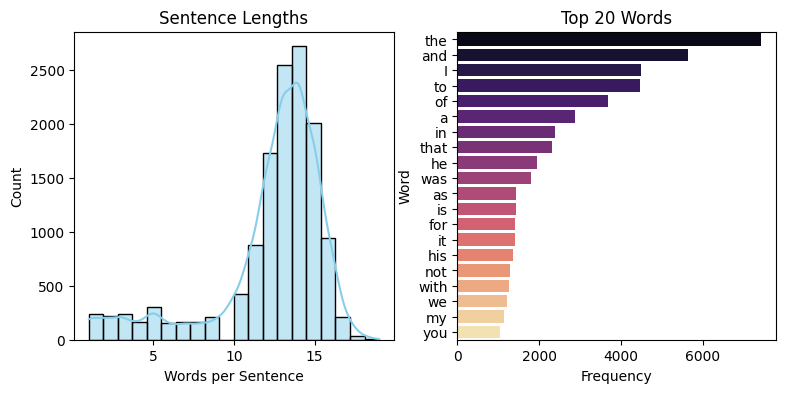

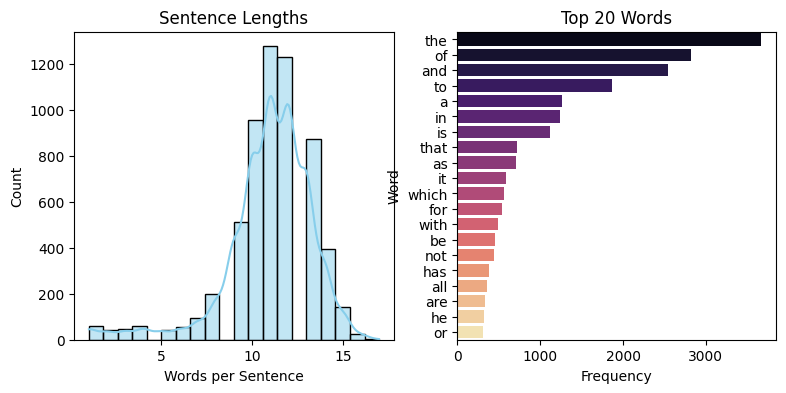

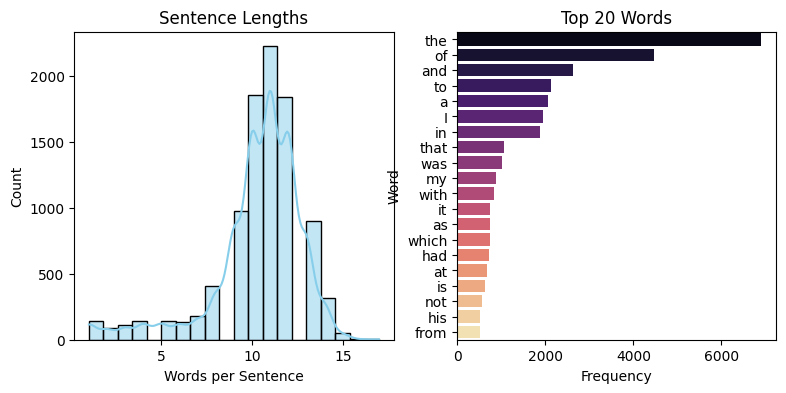

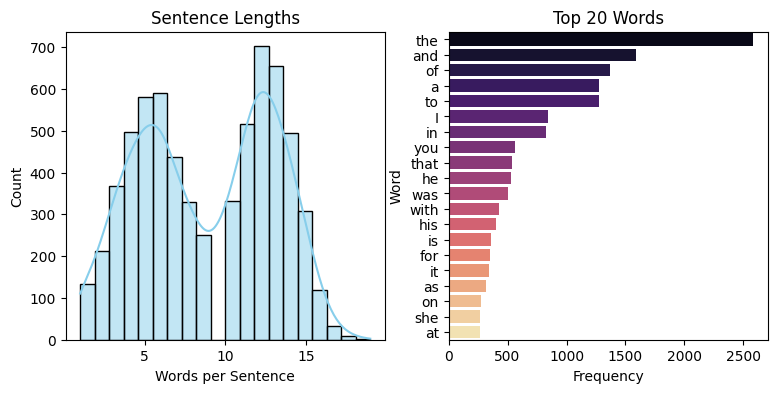

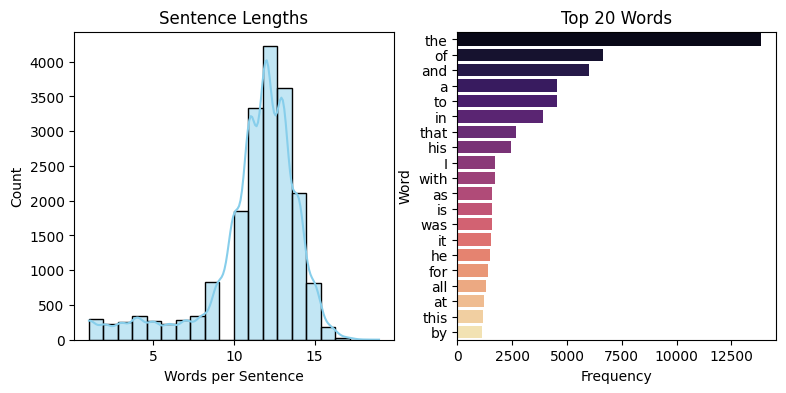

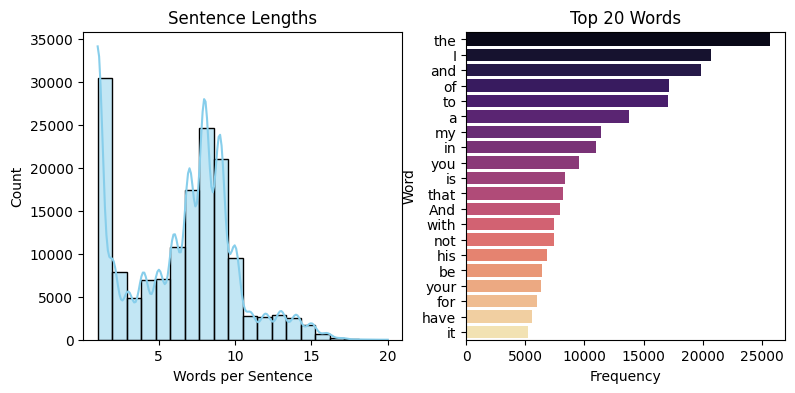

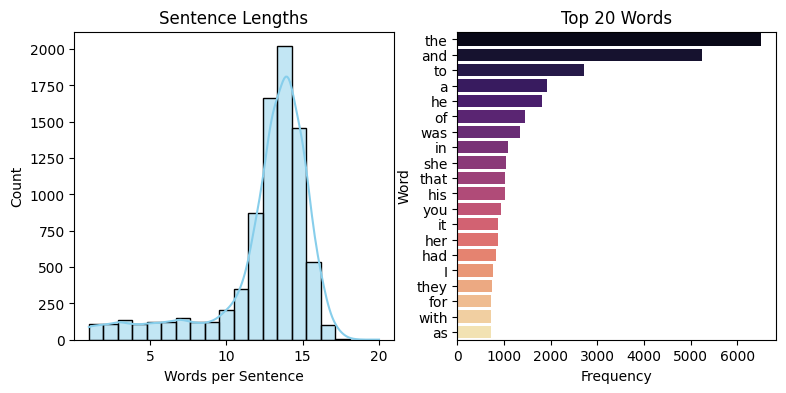

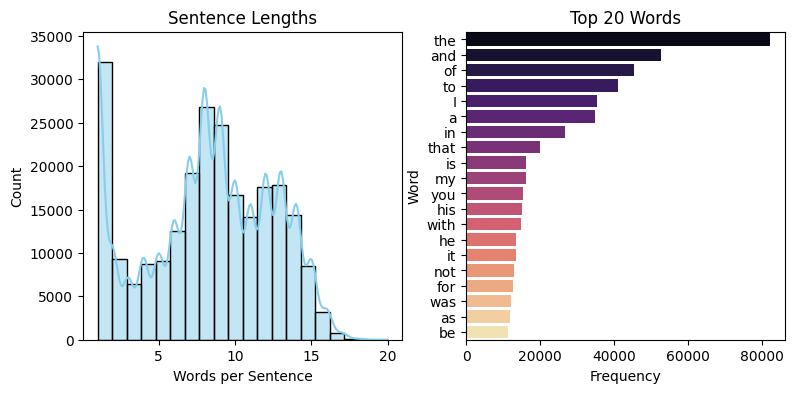

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# File list
file_list = [
    "alice_wonderland.txt", "life_mississippi.txt", "sherlock_holmes.txt", "dracula.txt", "good_and_evil.txt",
    "edgar_poe.txt", "wit_and_humor.txt", "moby_dick.txt", "shakespeare.txt", "grimms.txt"
]

# Load file contents
file_texts = {}
for filename in file_list:
    with open(filename, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
        file_texts[filename] = lines

# Define EDA function
def eda_for_file(filename, lines):
    tokenized_sentences = [line.split() for line in lines]
    all_words = [word for sentence in tokenized_sentences for word in sentence]
    sentence_lengths = [len(sentence) for sentence in tokenized_sentences]
    word_freq = Counter(all_words)
    most_common_words = word_freq.most_common(20)

    print(f"\n📄 {filename}")
    print(f"- Total sentences: {len(lines)}")
    print(f"- Total tokens: {len(all_words)}")
    print(f"- Unique tokens: {len(set(all_words))}")

    plt.figure(figsize=(14, 4))

    # Sentence Lengths
    plt.subplot(1, 3, 1)
    sns.histplot(sentence_lengths, bins=20, kde=True, color='skyblue')
    plt.title("Sentence Lengths")
    plt.xlabel("Words per Sentence")
    plt.ylabel("Count")

    # Top 20 Words
    plt.subplot(1, 3, 2)
    if most_common_words:
        words, freqs = zip(*most_common_words)
        sns.barplot(x=list(freqs), y=list(words), palette="magma")
        plt.title("Top 20 Words")
        plt.xlabel("Frequency")
        plt.ylabel("Word")

# Run EDA on each file
for filename in file_list:
    eda_for_file(filename, file_texts[filename])

# Optional: EDA on all combined files
all_lines = [line for lines in file_texts.values() for line in lines]
eda_for_file("ALL_COMBINED", all_lines)


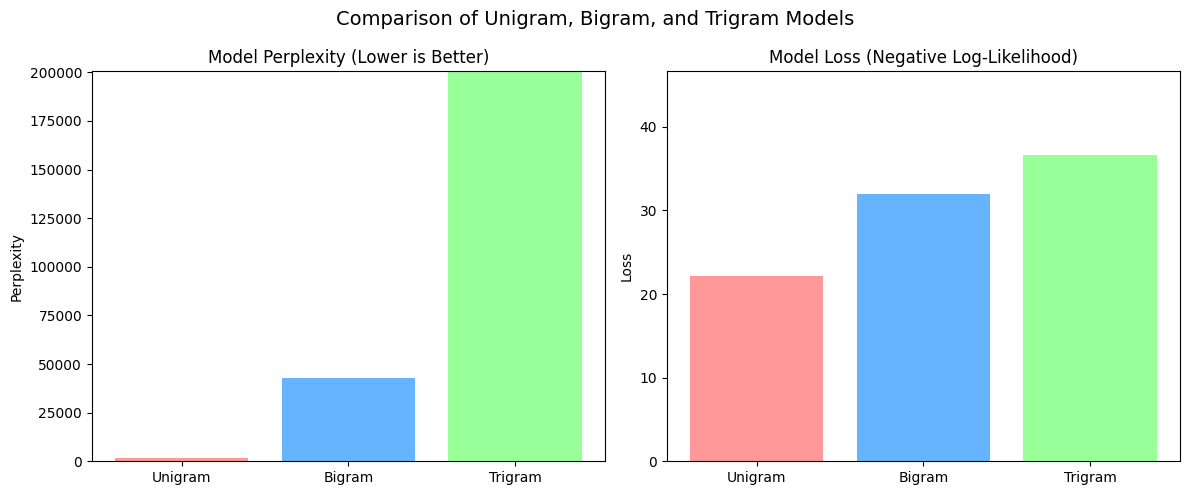

In [ ]:
import matplotlib.pyplot as plt

models = [unigram, bigram, trigram]
model_names = ["Unigram", "Bigram", "Trigram"]
test_sentence = "cometh here"


perplexities = [model.perplexity(test_sentence, smoothing="laplace") for model in models]
losses = [model.loss(test_sentence, smoothing="laplace") for model in models]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Perplexity bar chart
axs[0].bar(model_names, perplexities, color=["#ff9999", "#66b3ff", "#99ff99"])
axs[0].set_title("Model Perplexity (Lower is Better)")
axs[0].set_ylabel("Perplexity")
axs[0].set_ylim([0, max(perplexities) + 10])

# Loss bar chart
axs[1].bar(model_names, losses, color=["#ff9999", "#66b3ff", "#99ff99"])
axs[1].set_title("Model Loss (Negative Log-Likelihood)")
axs[1].set_ylabel("Loss")
axs[1].set_ylim([0, max(losses) + 10])

plt.suptitle("Comparison of Unigram, Bigram, and Trigram Models", fontsize=14)
plt.tight_layout()
plt.show()
